In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Load the dataset

In [402]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [386]:
TRAIN_DATA_PATH = "/kaggle/input/dogs-and-cats/cats_and_dogs_filtered/train"

TEST_DATA_PATH = "/kaggle/input/dogs-and-cats/cats_and_dogs_filtered/validation"

transformation = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [387]:
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transformation)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transformation)

We can check all classes in the train data.

In [388]:
train_data_cats.classes

['cats', 'dogs']

In [389]:
# Hyper parameters
num_epochs = 20
batchsize = 32
lr = 0.001

In [390]:
train_data_loader = td.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=4)
test_data_loader = td.DataLoader(test_data, batch_size=batchsize, shuffle=True,  num_workers=4)

## Visualizing the train data

In [391]:
import matplotlib.pyplot as plt

In [392]:
first_batch = next(iter(train_data_loader))
images, labels = first_batch  # Tách dữ liệu và nhãn

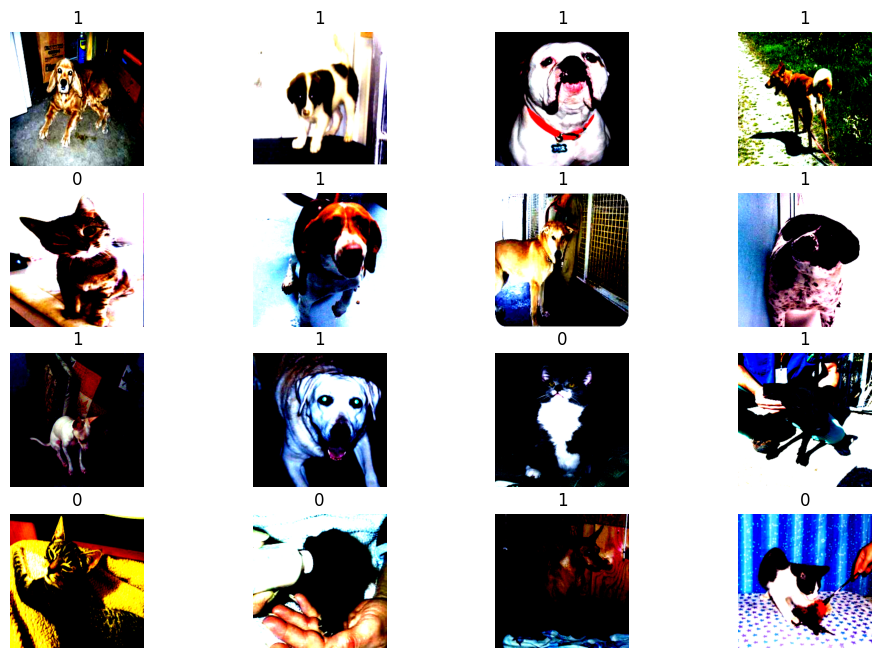

In [378]:
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(int(labels[i]))
    plt.axis('off')

## Define the model

In [393]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self.conv4 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self.fc1 = nn.Linear(32 * 15 * 15, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

## Train the model

In [394]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_data_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [395]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [396]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = CNN(in_channels=3, num_classes=2).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 20 epochs (in a real scenario, you'd likely use many more)
epochs = 20
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_data_loader, optimizer, epoch)
        test_loss = test(model, device, test_data_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/2000 (0%)] Loss: 0.692164
Training set [320/2000 (16%)] Loss: 0.690451
Training set [640/2000 (32%)] Loss: 0.696034
Training set [960/2000 (48%)] Loss: 0.681393
Training set [1280/2000 (63%)] Loss: 0.809770
Training set [1600/2000 (79%)] Loss: 0.636533
Training set [1920/2000 (95%)] Loss: 0.650518
Training set: Average loss: 0.683607
Validation set: Average loss: 0.648281, Accuracy: 618/1000 (62%)

Epoch: 2
Training set [0/2000 (0%)] Loss: 0.638231
Training set [320/2000 (16%)] Loss: 0.599768
Training set [640/2000 (32%)] Loss: 0.603052
Training set [960/2000 (48%)] Loss: 0.648305
Training set [1280/2000 (63%)] Loss: 0.689017
Training set [1600/2000 (79%)] Loss: 0.610834
Training set [1920/2000 (95%)] Loss: 0.600919
Training set: Average loss: 0.649175
Validation set: Average loss: 0.628228, Accuracy: 641/1000 (64%)

Epoch: 3
Training set [0/2000 (0%)] Loss: 0.624121
Training set [320/2000 (16%)] Loss: 0.842443
Training set [640/2000 (32%)] Los

Text(0, 0.5, 'Loss value')

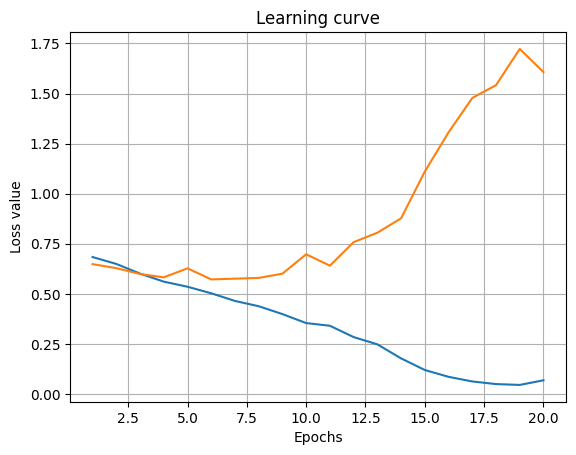

In [403]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.grid('True')
plt.title('Learning curve')
plt.xlabel('Epochs')
plt.ylabel('Loss value')

## Making prediction

In [346]:
def predict_image(classifier, image):
    import numpy

    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()

    if index == 1:
        print('This is a dog')
    else:
        print('This is a cat')
    return image

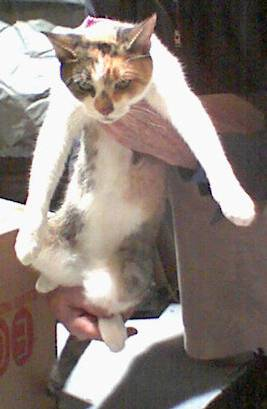

In [347]:
from PIL import Image

model = model.to('cpu')
image_path = "/kaggle/input/dogs-and-cats/cats_and_dogs_filtered/train/cats/cat.121.jpg"  
image = Image.open(image_path).convert("RGB")  
image

This is a cat


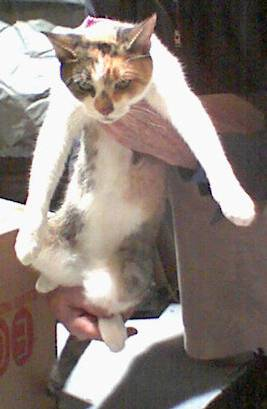

In [348]:
predict_image(model, image)

In [349]:
model_file = '/kaggle/working/models/cats_n_dogs_pytorch.pt'
torch.save(model, model_path)

In [353]:
pretrained_model = torch.load('/kaggle/working/model.pth')
pretrained_model

<ipython-input-353-4a81de03e9e8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load('/kaggle/working/model.pth')


CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7200, out_features=2, bias=True)
)

## Transfer Learning

In [404]:
# Load the model (download if not already present)
resnet50 = torchvision.models.resnet50(pretrained=True)

print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [405]:
classes = ['cat', 'dog']

In [406]:
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the prediction layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, len(classes))

# Now print the full model, which will include the feature extraction layers of the base model and our prediction layer
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [407]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
resnet50 = resnet50.to(device)

optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(resnet50, device, train_data_loader, optimizer, epoch)
        test_loss = test(resnet50, device, test_data_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/2000 (0%)] Loss: 0.768416
Training set [320/2000 (16%)] Loss: 0.402289
Training set [640/2000 (32%)] Loss: 0.164294
Training set [960/2000 (48%)] Loss: 0.218263
Training set [1280/2000 (63%)] Loss: 0.102096
Training set [1600/2000 (79%)] Loss: 0.254729
Training set [1920/2000 (95%)] Loss: 0.083914
Training set: Average loss: 0.267436
Validation set: Average loss: 0.084483, Accuracy: 983/1000 (98%)

Epoch: 2
Training set [0/2000 (0%)] Loss: 0.132079
Training set [320/2000 (16%)] Loss: 0.061617
Training set [640/2000 (32%)] Loss: 0.097743
Training set [960/2000 (48%)] Loss: 0.124720
Training set [1280/2000 (63%)] Loss: 0.059544
Training set [1600/2000 (79%)] Loss: 0.035034
Training set [1920/2000 (95%)] Loss: 0.091333
Training set: Average loss: 0.092273
Validation set: Average loss: 0.058309, Accuracy: 988/1000 (99%)

Epoch: 3
Training set [0/2000 (0%)] Loss: 0.066495
Training set [320/2000 (16%)] Loss: 0.317252
Training set [640/2000 (32%)] Los

Text(0, 0.5, 'Loss value')

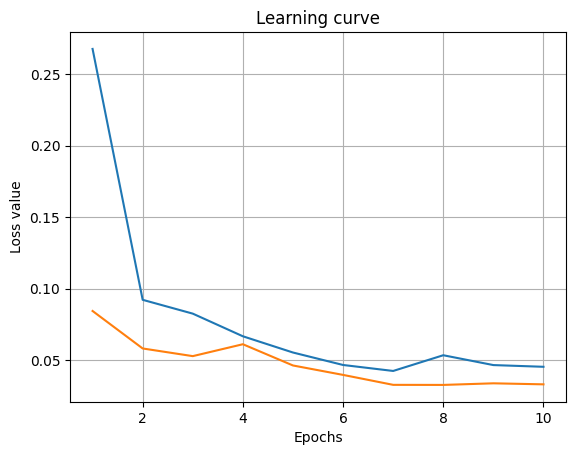

In [408]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.grid('True')
plt.title('Learning curve')
plt.xlabel('Epochs')
plt.ylabel('Loss value')

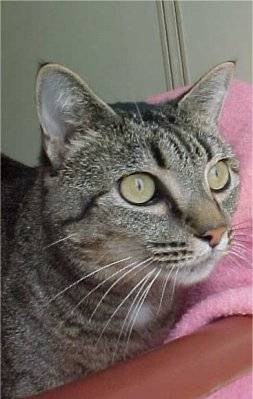

In [409]:
resnet50 = resnet50.to('cpu')
image_path = "/kaggle/input/dogs-and-cats/cats_and_dogs_filtered/train/cats/cat.104.jpg"  
image = Image.open(image_path).convert("RGB")  
image

This is a cat


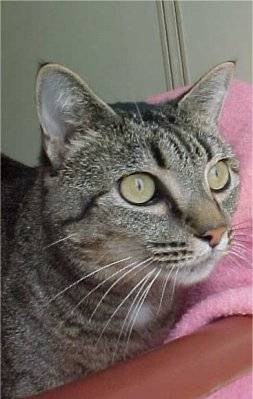

In [410]:
predict_image(resnet50, image)

In [412]:
resnet_finetuned = '/kaggle/working/cats_n_dogs_pytorch_finetuned.pt'
torch.save(model, resnet_finetuned)